# ИССЛЕДОВАНИЕ МЕТРИК ПРИЛОЖЕНИЯ Procrastinate Pro+ 

### Цель исследования:

Найти особенности и закономерности поведения пользователей в приложении Procrastinate Pro+. На основании этого устновить причину убытков от приложеия и предложить способы решения проблемы. 

### Ход исследования:

 - Предобработка данных
 - задание функций для расчёта и анализа LTV, ROI, удержания и конверсии 
 - исследовательский анализ данных
 - анализ маркетинга
 - оценка окупаемости рекламы
 
### Языки и библиотеки:

Python (pandas, matplotib, numpy, datetime)

### Вывод:

 Из полученных данных можно сделать вывод, что топовые рекламные канали, такие как FaceBoom, TipTop, AdNonSense несмотря на наилучшую конверсию в платящих пользователей все равно не окупаются. TipTop ввиду дороговизны привлечения в пересчете на одного клиента, причем в динамике цена только увеличивается, FaceBoom и AdNonSense имеют значительно более низктй процент удержания пользователей. Через американские рекламные каналы переходят основные пользователи iphone и MAC, от сюда такие просадки окупаемости по устройствам.

Рекомендуется комендуется сократить финансирование трех упомянутых рекламных каналов в пользу вложения средств в такие окупаемые каналы с нормальной конверсией и удержанием пользователей как: RocketSuperAds и YaRabbit для США и lambdaMediaAds и WahooNetBanner для Европы.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

In [2]:
try: 
    visits = pd.read_csv('D:\\Практикум\\visits_info_short.csv') # посещения
    orders = pd.read_csv('D:\\Практикум\\orders_info_short.csv')  # заказы
    costs = pd.read_csv('D:\\Практикум\\costs_info_short.csv')  # траты на рекламу
except:
    visits = pd.read_csv('/datasets/visits_info_short.csv') 
    orders = pd.read_csv('/datasets/orders_info_short.csv')
    costs = pd.read_csv('/datasets/costs_info_short.csv')

In [3]:
# Посмотрим на структуру датафреймов:
visits.head(5)

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


In [4]:
orders.head(5)

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


In [5]:
costs.head(5)

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


**ПРЕДОБРАБОТКА ДАННЫХ**

In [6]:
#Разберем каждый датафрейм по отдельности:

#Visits:

visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


Количество ненулевых строк одининаковое, скорее всего пропусков строках нет. Бросается в галаза регистр и отступы в названии столбцовб, а также тип данных столбцов со временем сессий. Испарвим это:  

In [7]:
#Приведем название столбцов к общепринятому стилю:

visits.columns = [x.lower().replace(' ', '_') for x in visits.columns.values] 

In [8]:
#Изменение типа данных

visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])

In [9]:
#Убедимся в отсутвии пропусков:

pd.DataFrame(round(visits.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
user_id,0.000000
region,0.000000
device,0.000000
channel,0.000000
session_start,0.000000
session_end,0.000000


In [10]:
# Проверка на дубликаты:

visits.duplicated().sum()

0

In [11]:
# Столбец orders: 

orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


В данном случае аналогичная ситуация со столбцами, проведем те же манипуляции: 

In [12]:
orders.columns = [x.lower().replace(' ', '_') for x in orders.columns.values] 

In [13]:
orders['event_dt'] = pd.to_datetime(orders['event_dt'])

In [14]:
pd.DataFrame(round(orders.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
user_id,0.000000
event_dt,0.000000
revenue,0.000000


In [15]:
orders.duplicated().sum()

0

In [16]:
# Столбец costs: 

costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


Данный столбец скорректируем так же, как предидущие, кроме пробелов между словами, и преобразуем столбец dt в дату: 

In [17]:
costs.columns = [x.lower() for x in costs.columns.values] 

In [18]:
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

In [19]:
pd.DataFrame(round(costs.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
dt,0.000000
channel,0.000000
costs,0.000000


In [20]:
costs.duplicated().sum()

0

In [21]:
# Проверим результат:

visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB


In [22]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.6 KB


In [23]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


Вывод: Грубых недостатков в данных не выявлено, были изменен стыль столбцов и тип дынных в столбцах с датами

**ФУНКЦИИ ДЛЯ РАСЧЕТА И АНАЛИЗА LTV, ROI, УДЕРЖАНИЯ И КОНВЕРСИИ:**

In [24]:
#get_profiles() — для создания профилей пользователей

def get_profiles(sessions, orders, costs):
    # находим параметры первых посещений
    profiles = (sessions.sort_values(by=['user_id', 'session_start'])
                .groupby('user_id')
                .agg(
                    {
                        'session_start' : 'first',
                        'channel' : 'first',
                        'device' : 'first',
                        'region' : 'first'
                    }
                )
                .rename(columns={'session_start' : 'first_ts'})
                .reset_index()
               )
    
    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')
    
    # добавляем признак пользователей, совершивших покупку
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())
    
    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )
    
    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = costs.merge(new_users, on=['dt', 'channel'], how='left')
    
    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']
    
    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)
    
    return profiles

In [25]:
# get_retention() — для подсчёта Retention Rate

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):
    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions
    
    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days=horizon_days - 1)
    result_raw  = profiles.query('dt <= @last_suitable_acquisition_date')
    
    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days
    
    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [26]:
# get_conversion() — для подсчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [27]:
# get_ltv() — для подсчёта LTV

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

In [28]:
# Функции для построния графиков: 

# filter_data() — для сглаживания данных

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [29]:
# plot_retention() — для построения графика Retention Rate

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [30]:
# plot_conversion() — для построения графика конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [31]:
# plot_ltv_roi — для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

**ИССЛЕЛОВАТЕЛЬСКИЙ АНАЛИЗ ДАННЫХ**

In [32]:
# Составим профили пользователей: 

profiles = get_profiles(visits, orders, costs)
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


In [33]:
# Определим минимальную и максимальную даты привлечения пользователей:

print(f'Минимальная дата привлечения пользователей {profiles.first_ts.dt.date.min()}')
print(f'Максимальная дата привлечения пользователей {profiles.first_ts.dt.date.max()}')

Минимальная дата привлечения пользователей 2019-05-01
Максимальная дата привлечения пользователей 2019-10-27


In [34]:
#Точку наблюдения возьмем условно-сегодняшний день: 1 ноября 2019 года.
# Вбизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. Значит возьмем качестве горизонта анализа 14 дней.

observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа

In [35]:
#Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. 
#Постройте таблицу, отражающую количество пользователей и долю платящих из каждой страны.

profiles['region'].unique()

array(['United States', 'France', 'Germany', 'UK'], dtype=object)

In [36]:
# Функция для разбивки по странам, каналам и девайсам:  

def fun(var):
    grouped_users = profiles.groupby(var)['user_id'].nunique().reset_index()
    grouped_payers = profiles[profiles['payer'] == True].groupby(var)['user_id'].nunique().reset_index()
    profiles_grouped = grouped_users.merge(grouped_payers, on=var, how='left')
    profiles_grouped.columns=(var, 'id_count', 'payer_count')
    profiles_grouped['payer_rate'] = profiles_grouped['payer_count'] / profiles_grouped['id_count']
    profiles_grouped.sort_values(by='id_count', ascending=False).reset_index()
    return profiles_grouped

In [37]:
region_users = fun('region')
region_users.style.format({'payer_rate': '{:.2%}'})

,region,id_count,payer_count,payer_rate
0,France,17450,663,3.80%
1,Germany,14981,616,4.11%
2,UK,17575,700,3.98%
3,United States,100002,6902,6.90%


 Визуализируем таблицу:

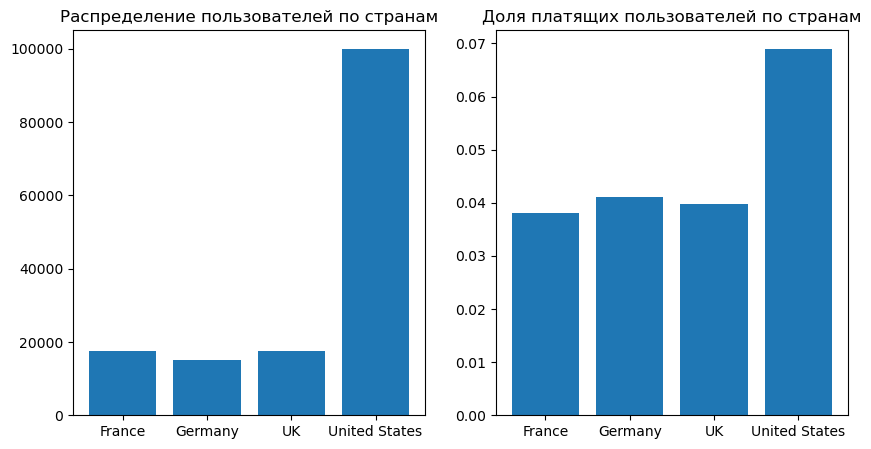

In [38]:
plt.figure(figsize=(10, 5))
ax1 = plt.subplot(1, 2, 1)
plt.bar(x=region_users['region'], height=region_users['id_count'])
plt.title('Распределение пользователей по странам')

ax2 = plt.subplot(1, 2, 2)
plt.bar(x=region_users['region'], height=region_users['payer_rate'])
plt.title('Доля платящих пользователей по странам')
plt.show()


США лидирует по числу пользователей. то же самое можно сказать о доле платящих пользователей 

In [39]:
#Узнаем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи.
#Построим таблицу, отражающую количество пользователей и долю платящих для каждого устройства.
profiles['device'].unique()

array(['Mac', 'iPhone', 'PC', 'Android'], dtype=object)

In [40]:
device_users = fun('device')
device_users.style.format({'payer_rate': '{:.2%}'})

,device,id_count,payer_count,payer_rate
0,Android,35032,2050,5.85%
1,Mac,30042,1912,6.36%
2,PC,30455,1537,5.05%
3,iPhone,54479,3382,6.21%


Визуализируем таблицу и сделаем выводы:

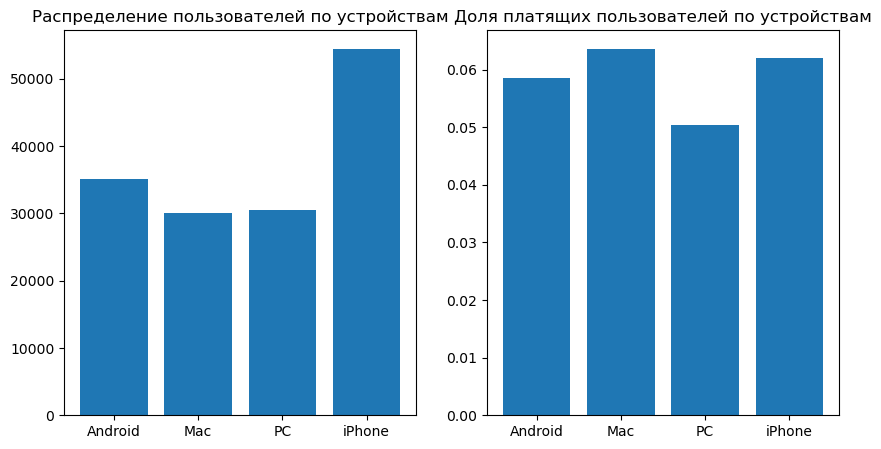

In [41]:
plt.figure(figsize=(10, 5))
ax1 = plt.subplot(1, 2, 1)
ax1.bar(x=device_users['device'], height=device_users['id_count'])
plt.title('Распределение пользователей по устройствам')

ax2 = plt.subplot(1, 2, 2)
plt.bar(x=device_users['device'], height=device_users['payer_rate'])
plt.title('Доля платящих пользователей по устройствам')

plt.show()

Доля платящих пользователей приблизотельно одинаковая, особенно по сравненнию с графиком распределения по странам. 

In [42]:
# Изучим рекламные источники привлечения и определим каналы, из которых пришло больше всего платящих пользователей. 
# Построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.
channel_users = fun('channel')
channel_users.style.format({'payer_rate': '{:.2%}'})

,channel,id_count,payer_count,payer_rate
0,AdNonSense,3880,440,11.34%
1,FaceBoom,29144,3557,12.20%
2,LeapBob,8553,262,3.06%
3,MediaTornado,4364,156,3.57%
4,OppleCreativeMedia,8605,233,2.71%
5,RocketSuperAds,4448,352,7.91%
6,TipTop,19561,1878,9.60%
7,WahooNetBanner,8553,453,5.30%
8,YRabbit,4312,165,3.83%
9,lambdaMediaAds,2149,225,10.47%


In [43]:
# Посмотрим на распределение рекламных каналов по регионам: 

region_channels = profiles[profiles['payer'] == True].pivot_table(
    index='channel', columns='region', values='user_id', aggfunc='count').query('channel != "organic"').sort_values(
    by='United States', ascending=False
).reset_index()
region_channels

region,channel,France,Germany,UK,United States
0,FaceBoom,NaN,NaN,NaN,3557.0
1,TipTop,NaN,NaN,NaN,1878.0
2,RocketSuperAds,NaN,NaN,NaN,352.0
3,YRabbit,NaN,NaN,NaN,165.0
4,MediaTornado,NaN,NaN,NaN,156.0
5,AdNonSense,150.0,142.0,148.0,NaN
6,LeapBob,90.0,69.0,103.0,NaN
7,OppleCreativeMedia,80.0,64.0,89.0,NaN
8,WahooNetBanner,152.0,148.0,153.0,NaN
9,lambdaMediaAds,82.0,67.0,76.0,NaN


Оказывается, канали Европы и США не пересекаются эти региона по-отдельности: 

In [44]:
usa_channels = region_channels.loc[region_channels['United States'] > 0,'channel']
eu_channels = region_channels.loc[(
    region_channels['UK'] > 0),'channel']

In [45]:
total_usa_channels = channel_users.query('channel in @usa_channels').sort_values(
    by='payer_rate', ascending=False).reset_index(drop=True)
total_usa_channels

,channel,id_count,payer_count,payer_rate
0,FaceBoom,29144,3557,0.122049
1,TipTop,19561,1878,0.096007
2,RocketSuperAds,4448,352,0.079137
3,YRabbit,4312,165,0.038265
4,MediaTornado,4364,156,0.035747


In [46]:
total_eu_channels = channel_users.query('channel in @eu_channels').sort_values(
    by='payer_rate', ascending=False).reset_index(drop=True)
total_eu_channels

,channel,id_count,payer_count,payer_rate
0,AdNonSense,3880,440,0.113402
1,lambdaMediaAds,2149,225,0.104700
2,WahooNetBanner,8553,453,0.052964
3,LeapBob,8553,262,0.030633
4,OppleCreativeMedia,8605,233,0.027077


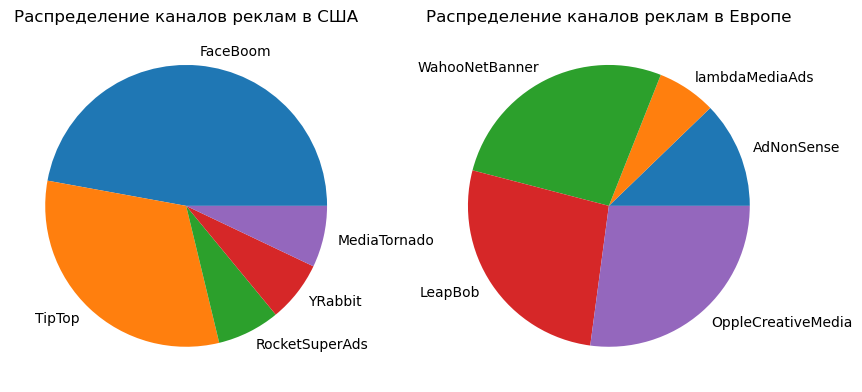

In [47]:
plt.figure(figsize=(10, 10))
ax1 = plt.subplot(1, 2, 1)
ax1.pie(total_usa_channels['id_count'], labels=total_usa_channels['channel'])
plt.title('Распределение каналов реклам в США')


ax2= plt.subplot(1, 2, 2)
ax2.pie(total_eu_channels['id_count'], labels=total_eu_channels['channel'])
plt.title('Распределение каналов реклам в Европе')

plt.show()

В США лидирует рекламодатель FaceBoom, В Европе нет явного лидера

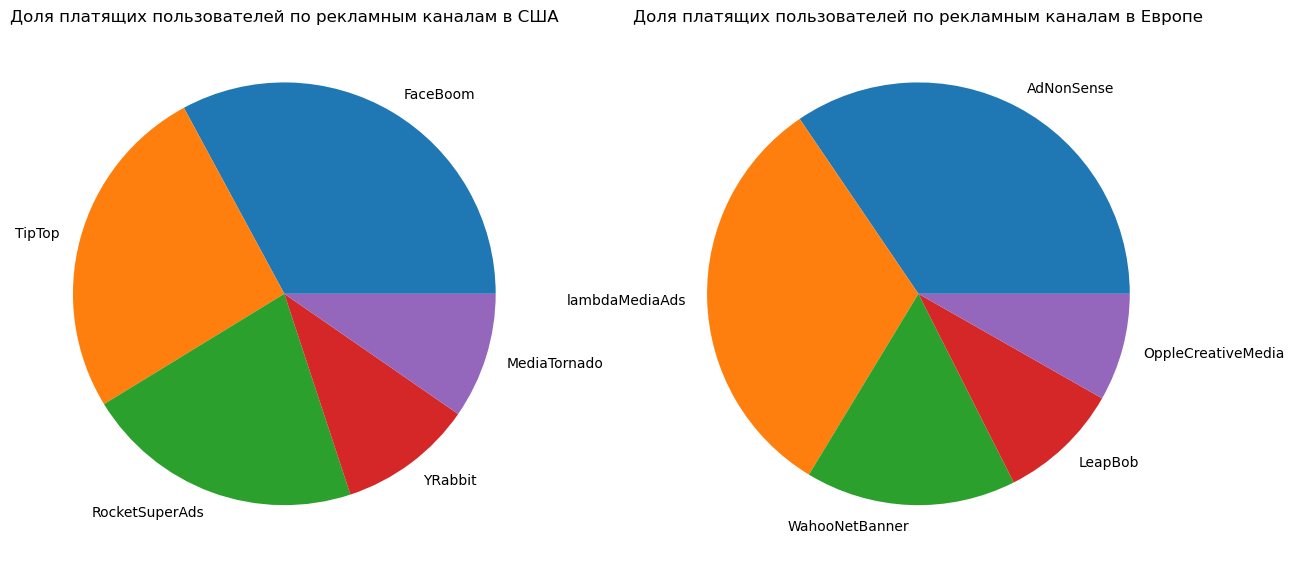

In [48]:
plt.figure(figsize=(15, 15))
ax1 = plt.subplot(1, 2, 1)
ax1.pie(total_usa_channels['payer_rate'], labels=total_usa_channels['channel'])
plt.title('Доля платящих пользователей по рекламным каналам в США')


ax2= plt.subplot(1, 2, 2)
ax2.pie(total_eu_channels['payer_rate'], labels=total_eu_channels['channel'])
plt.title('Доля платящих пользователей по рекламным каналам в Европе')
plt.show()

По проценту плотящих ползователей в США лидирует FaceBoom, в Европе, с небольшим отрывом - AdNonSense.

Вывод:  
- Наибольшее количество человек используют приложение в США, то же самое можно сказать про долю платящих пользователей. 
- Самое популярное устройство - iphone, однако по доле платящих пользователей его немного опережает Mac.
- Рекламные источники в США и Европе не пересекаются друг с другом. Любопытно, что в европе самые небольшие по охвату рекламодатели имеют наибольший процент платящих пользователей.

**АНАЛИЗ МАРКЕТИНГА**

In [49]:
# Найдем общую сумму расходов на маркетинг:

costs['costs'].sum()

105497.30000000002

In [50]:
# Узнаем, как траты распределены по рекламным источникам:

costs.groupby('channel')['costs'].sum().sort_values(ascending=False).reset_index()

,channel,costs
0,TipTop,54751.30
1,FaceBoom,32445.60
2,WahooNetBanner,5151.00
3,AdNonSense,3911.25
4,OppleCreativeMedia,2151.25
5,RocketSuperAds,1833.00
6,LeapBob,1797.60
7,lambdaMediaAds,1557.60
8,MediaTornado,954.48
9,YRabbit,944.22


Наиболее большими оказались вложения в канал TipTop, на втором местее FaceBoom. Оба эти рекламодателя из США. На 3 месте с большим отрывом идет европейский канал WahooNetBanner 

In [51]:
costs

,dt,channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1
...,...,...,...
1795,2019-10-23,lambdaMediaAds,4.0
1796,2019-10-24,lambdaMediaAds,6.4
1797,2019-10-25,lambdaMediaAds,8.8
1798,2019-10-26,lambdaMediaAds,8.8


Построим визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику:

In [52]:
costs['month'] = costs['dt'].astype('datetime64[M]')

In [53]:
costs['week'] = costs['dt'].astype('datetime64[W]')

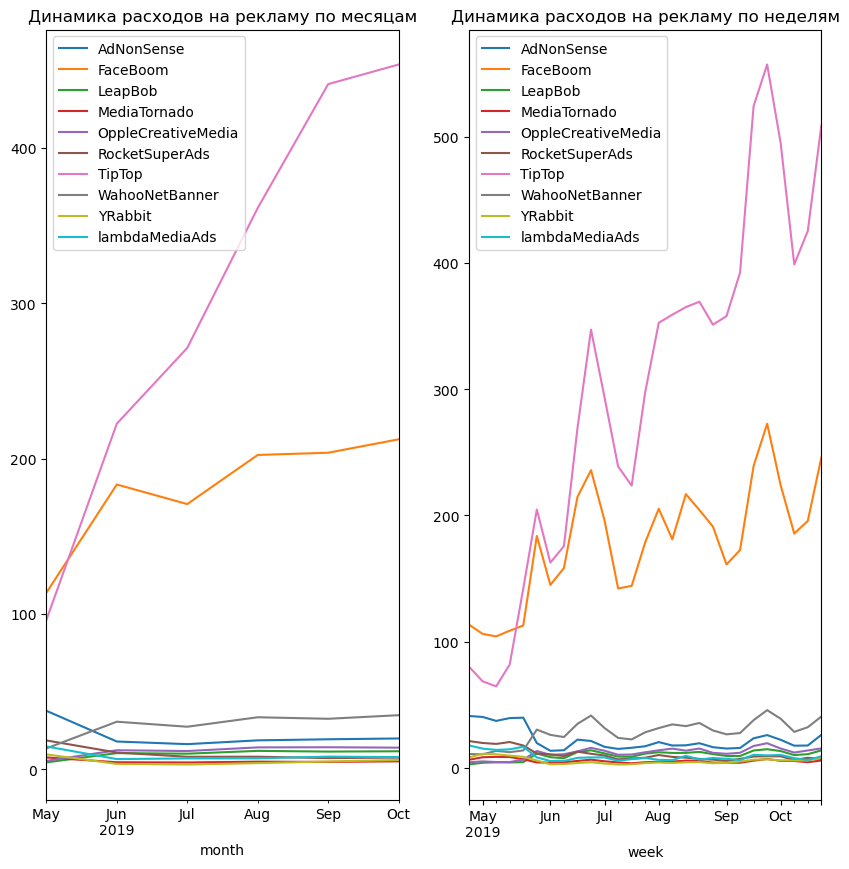

In [54]:
plt.figure(figsize=(10, 10))
ax1 = plt.subplot(1, 2, 1)
costs.pivot_table(index='month', columns='channel',values='costs', aggfunc='mean').plot(ax=ax1)
plt.title('Динамика расходов на рекламу по месяцам')
plt.legend()


ax2 = plt.subplot(1, 2, 2)
costs.pivot_table(index='week', columns='channel',values='costs', aggfunc='mean').plot(ax=ax2)
plt.title('Динамика расходов на рекламу по неделям')
plt.legend()

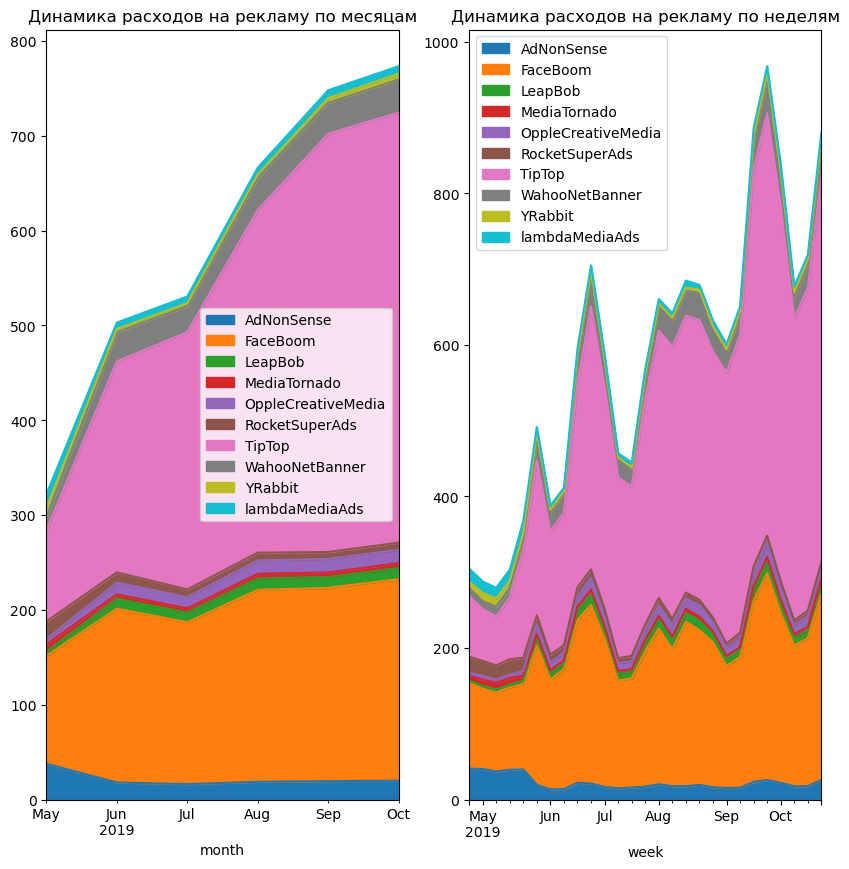

In [55]:
# Код ревьюера

plt.figure(figsize=(10, 10))
ax1 = plt.subplot(1, 2, 1)
costs.pivot_table(index='month', columns='channel',values='costs', aggfunc='mean').plot.area(ax=ax1)
plt.title('Динамика расходов на рекламу по месяцам')
plt.legend()


ax2 = plt.subplot(1, 2, 2)
costs.pivot_table(index='week', columns='channel',values='costs', aggfunc='mean').plot.area(ax=ax2)
plt.title('Динамика расходов на рекламу по неделям')
plt.legend()

Мы набдаем резкий рост расходов на самые крупные рекламные каналы: американских FaceBoom и TikTop и европейского WahooNetBanner. Действительно, эти каналы привлекли больше всего пльзователей, одна, как было замечено ранее, процент платящих пользователей гораздо ниже, чем в других каналих. Будем разбираться дальше. 

In [56]:
# 
cost_users = channel_users.merge(
    costs.groupby('channel')['costs'].sum(), on = 'channel', how = 'left'
)
cost_users = cost_users.query('channel != "organic"')

In [57]:
cost_users['cac'] = cost_users['costs'] / cost_users['id_count']

cost_users.sort_values(by='cac', ascending = False)

,channel,id_count,payer_count,payer_rate,costs,cac
6,TipTop,19561,1878,0.096007,54751.30,2.799003
1,FaceBoom,29144,3557,0.122049,32445.60,1.113286
0,AdNonSense,3880,440,0.113402,3911.25,1.008054
9,lambdaMediaAds,2149,225,0.104700,1557.60,0.724802
7,WahooNetBanner,8553,453,0.052964,5151.00,0.602245
5,RocketSuperAds,4448,352,0.079137,1833.00,0.412095
4,OppleCreativeMedia,8605,233,0.027077,2151.25,0.250000
8,YRabbit,4312,165,0.038265,944.22,0.218975
3,MediaTornado,4364,156,0.035747,954.48,0.218717
2,LeapBob,8553,262,0.030633,1797.60,0.210172


Вывод: Самыми дорогими по привлевлечению пользователей оказались американские TipTop FaceBoom, а так же европейские AdNonSense и ambdaMediaAds, но при этом они приносят наибольший процент платящих пользователей.
Реклама в США и Европе не пересекается друг с другом и имеет разные закономерности:
самые крупные по охвату реклмодатели США в то же время являются самыми дорогими, в то время как в Европе самыми дорогими являются самые маленькие по охвату каналы. 

    

**ОЕНКА ОКУПАЕМОСТИ РЕКЛАМЫ**

Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI:

In [58]:
# Исключим органиков из Profiles:

profiles_adv = profiles.query('channel != "organic"')

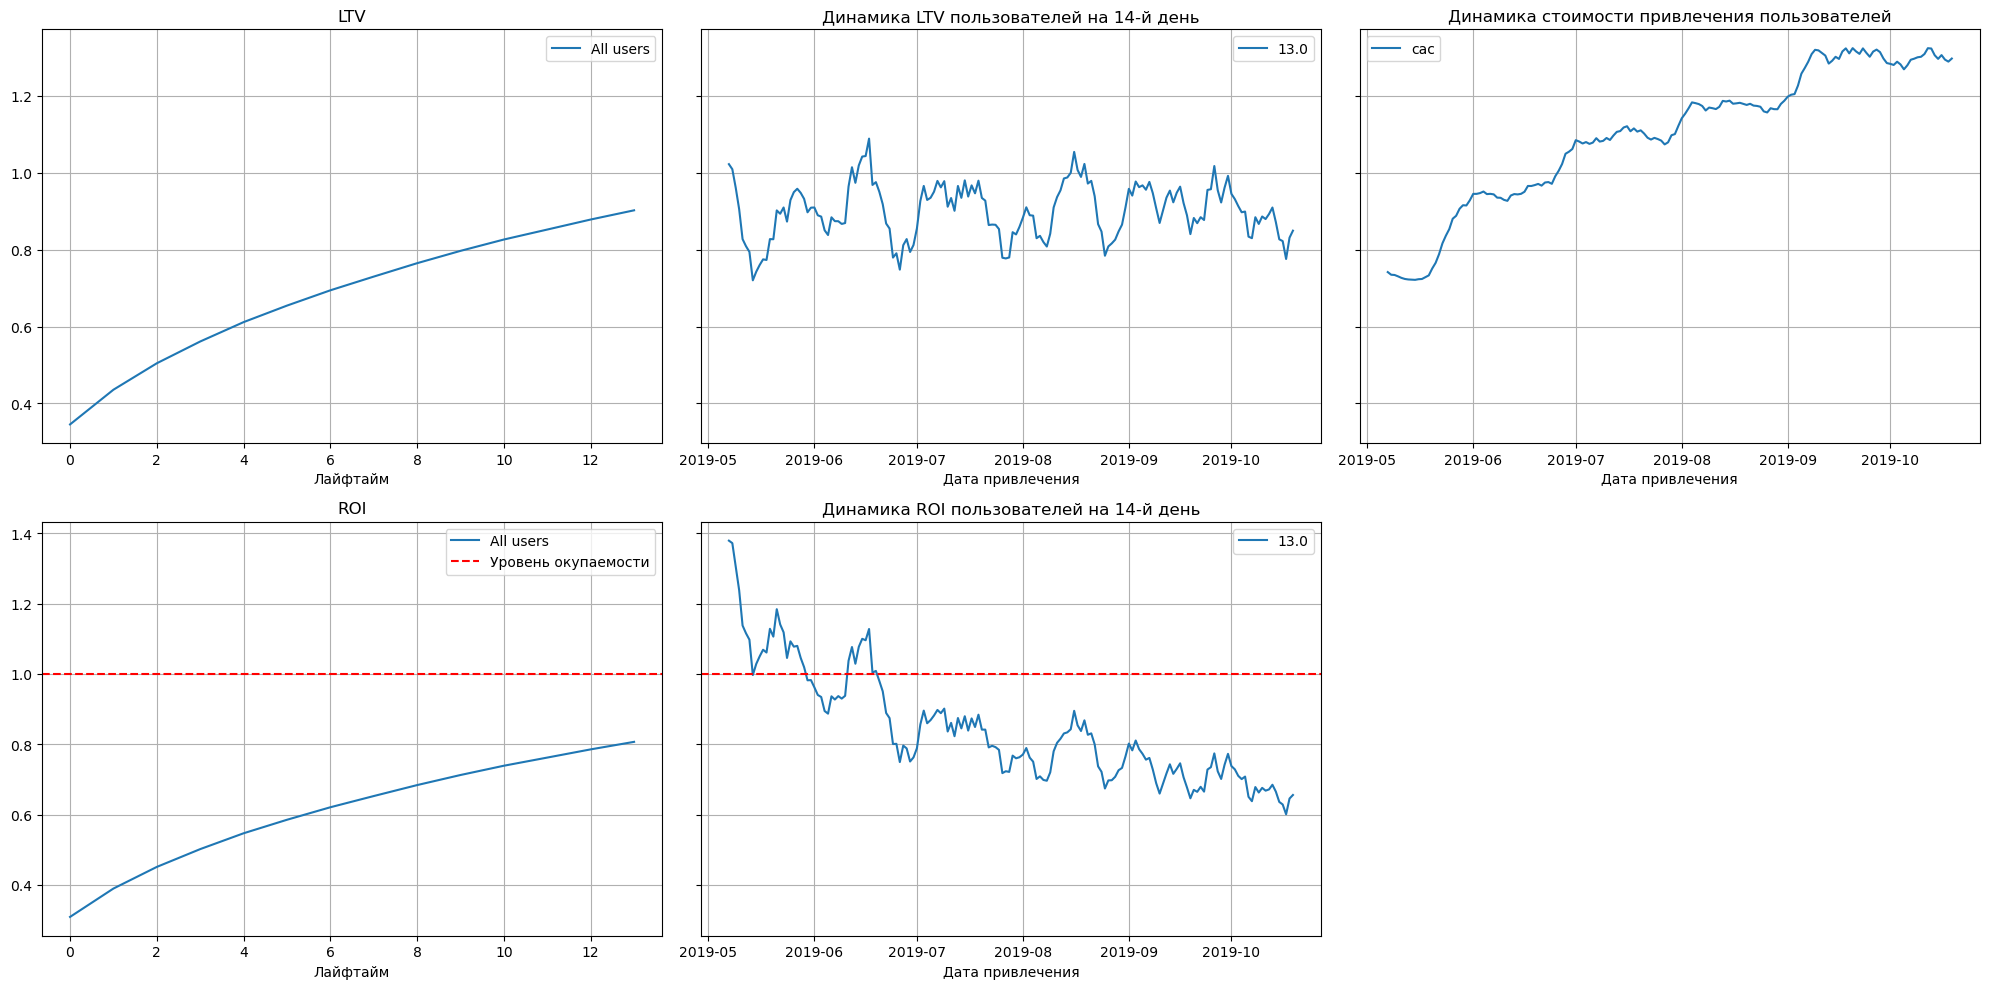

In [59]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(profiles_adv, orders, observation_date, horizon_days)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

Мы можем наблюдать, что динамика LTV полльзователей была скачкообразной, но ростом это не назвать, в то время как стоимость привлечения пользователей стабильно увеличивалась за ичучаемый период. Из этого следует, что динамика ROI идет вниз при том, что изучаемые когорты и так не смогли достичь уровняокупаемости.

In [60]:
# Построим графики конверсии и удержания: 

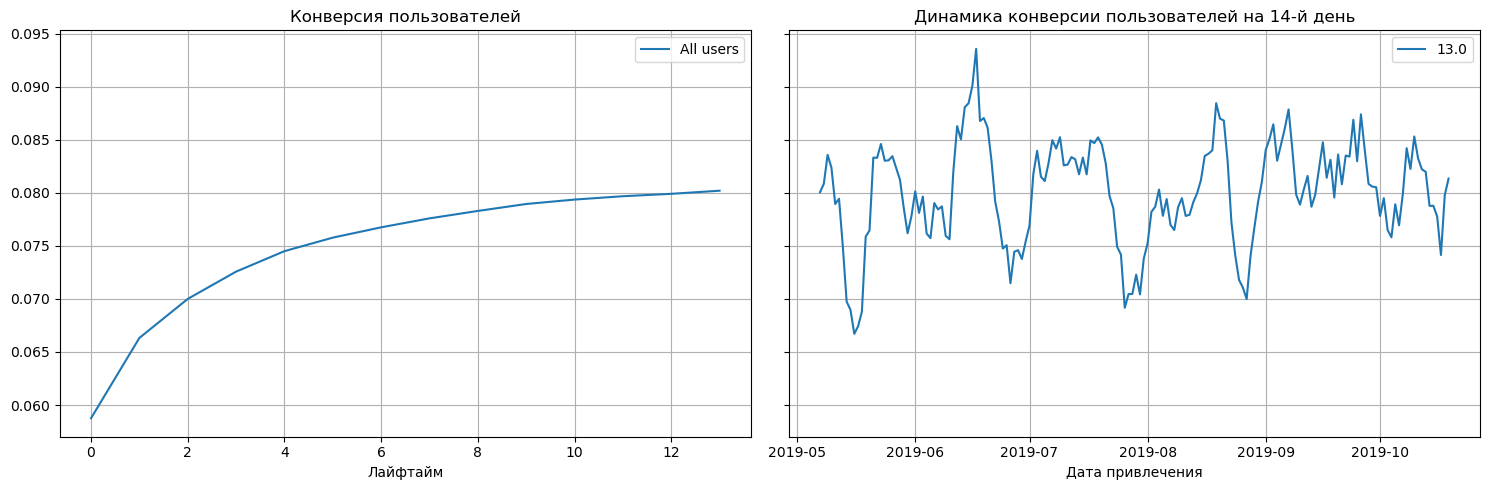

In [61]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_adv, orders, observation_date, horizon_days
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Конверсия пользователей растет, онако после 4го лайфтайма рост замедляется. Динамика к концу изсучаемого периода стала менее скачкообразной и осталась на прежнем уровне.

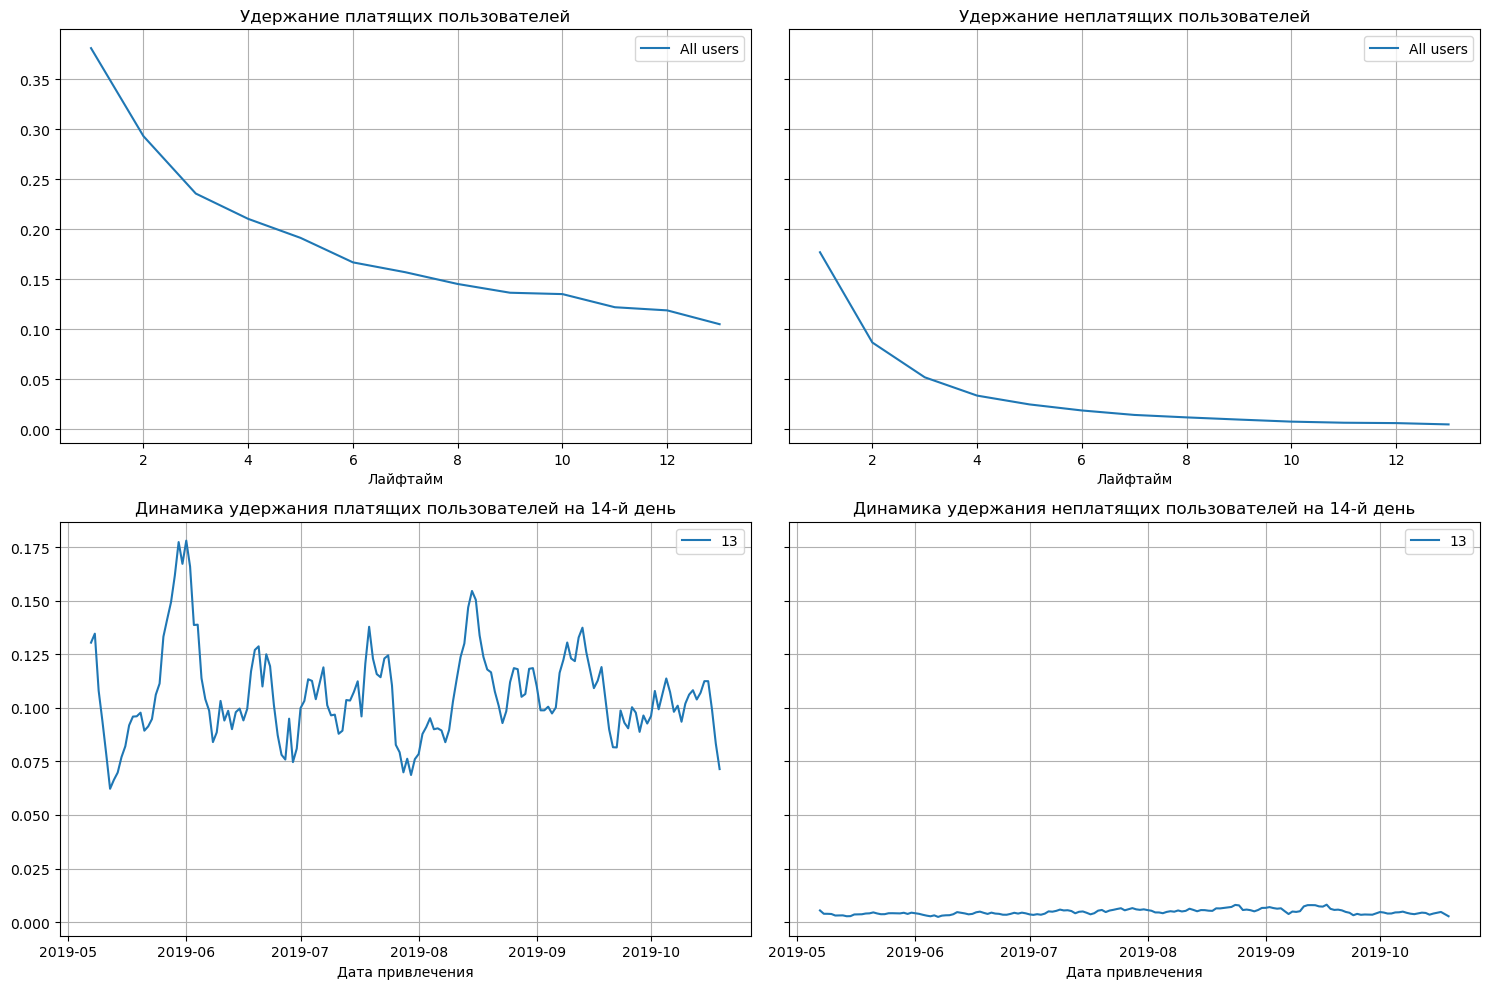

In [62]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles_adv, visits, observation_date, horizon_days
)

plot_retention(retention_grouped, retention_history, horizon_days)

Ожидаемо удержание платящих пользователей выше как в динамике, так и в абсолютных числах. Однако можно заметить, что динамика платящих несколько снижается. 

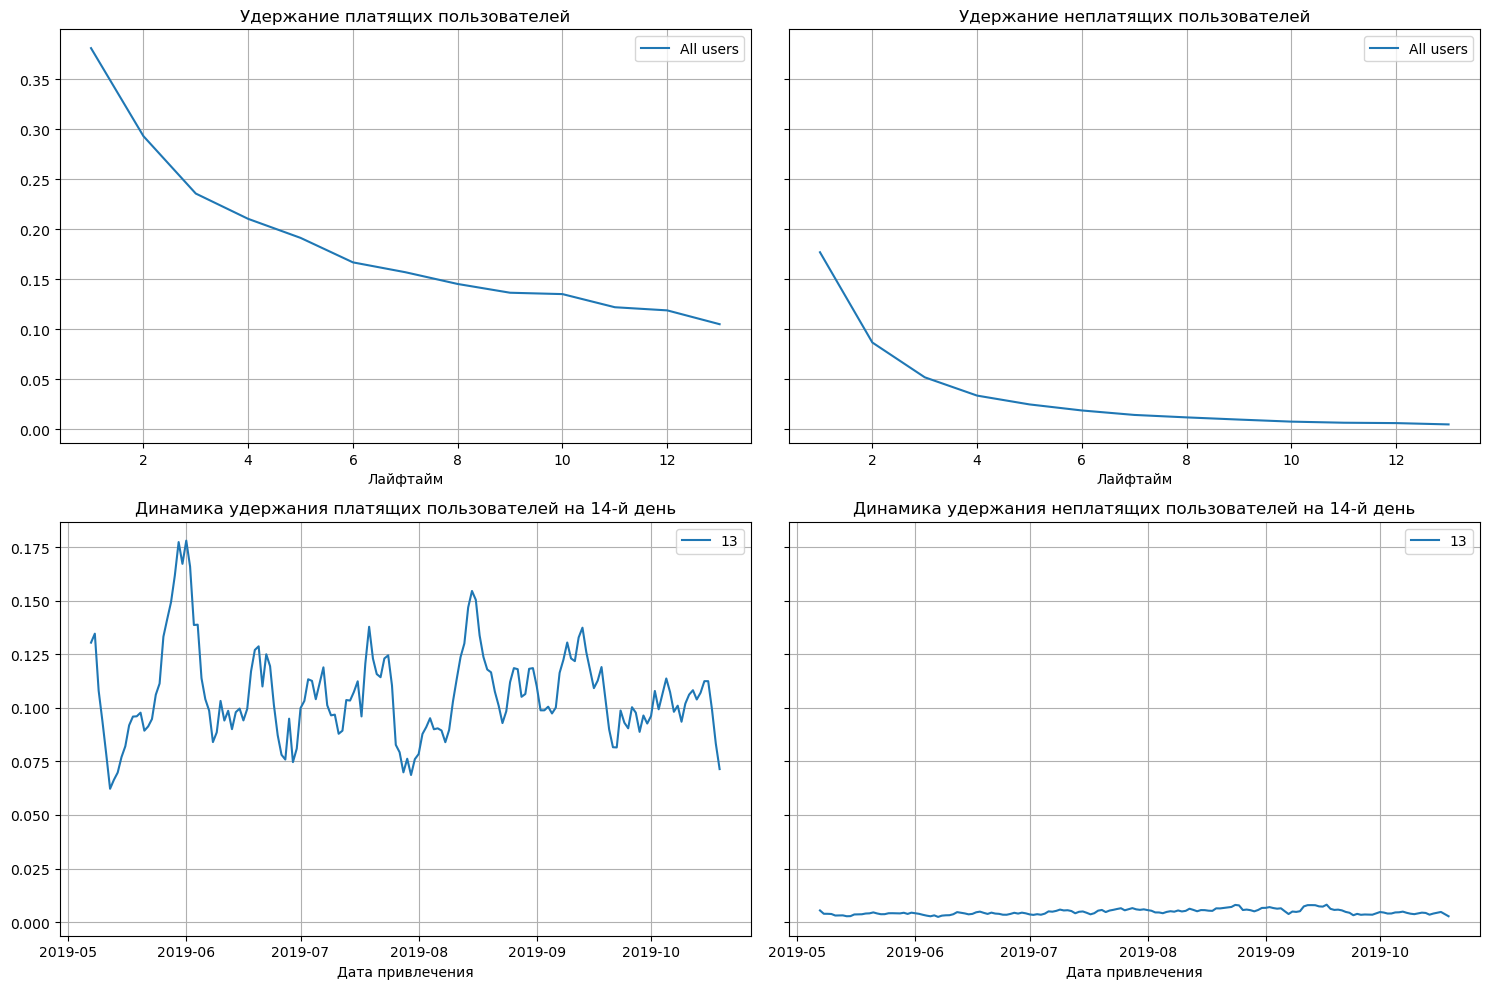

In [63]:

retention_raw, retention_grouped, retention_history = get_retention(
    profiles_adv, visits, observation_date, horizon_days
)

plot_retention(retention_grouped, retention_history, horizon_days)

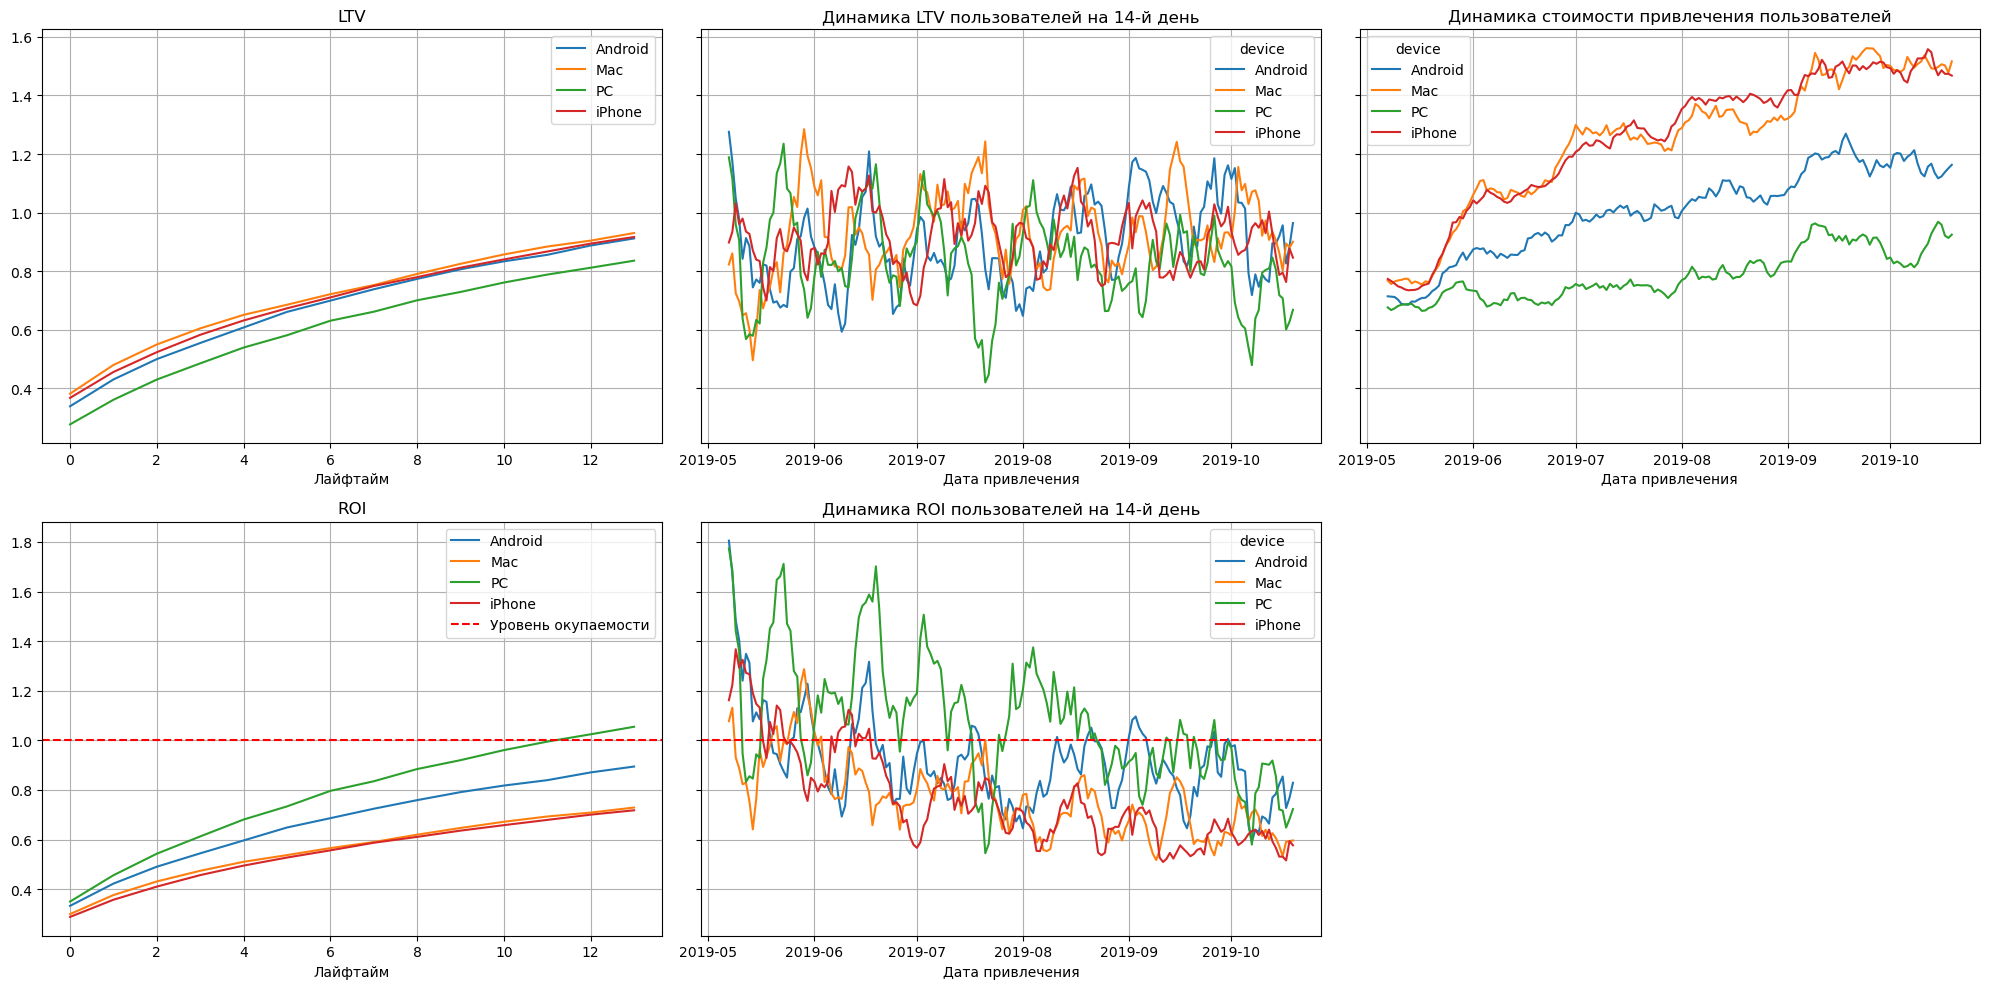

In [64]:
# Рассмотрим окупаемость рекламы с разбивкой по устройствам:

dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_adv, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=7
)

LTV у PC заметно ниже, чем у других устройств, то же самое можно сказать про динамику LTV. Однако, это единственная платформа, которая смогла окупиться. Важно отметить, что у PC самая низкая стоиомсть привлечения пользователей и самая высокая динамика ROI. Полностью проитвоположные значения имеют утсройства Apple. Android также не смог окупиться.   

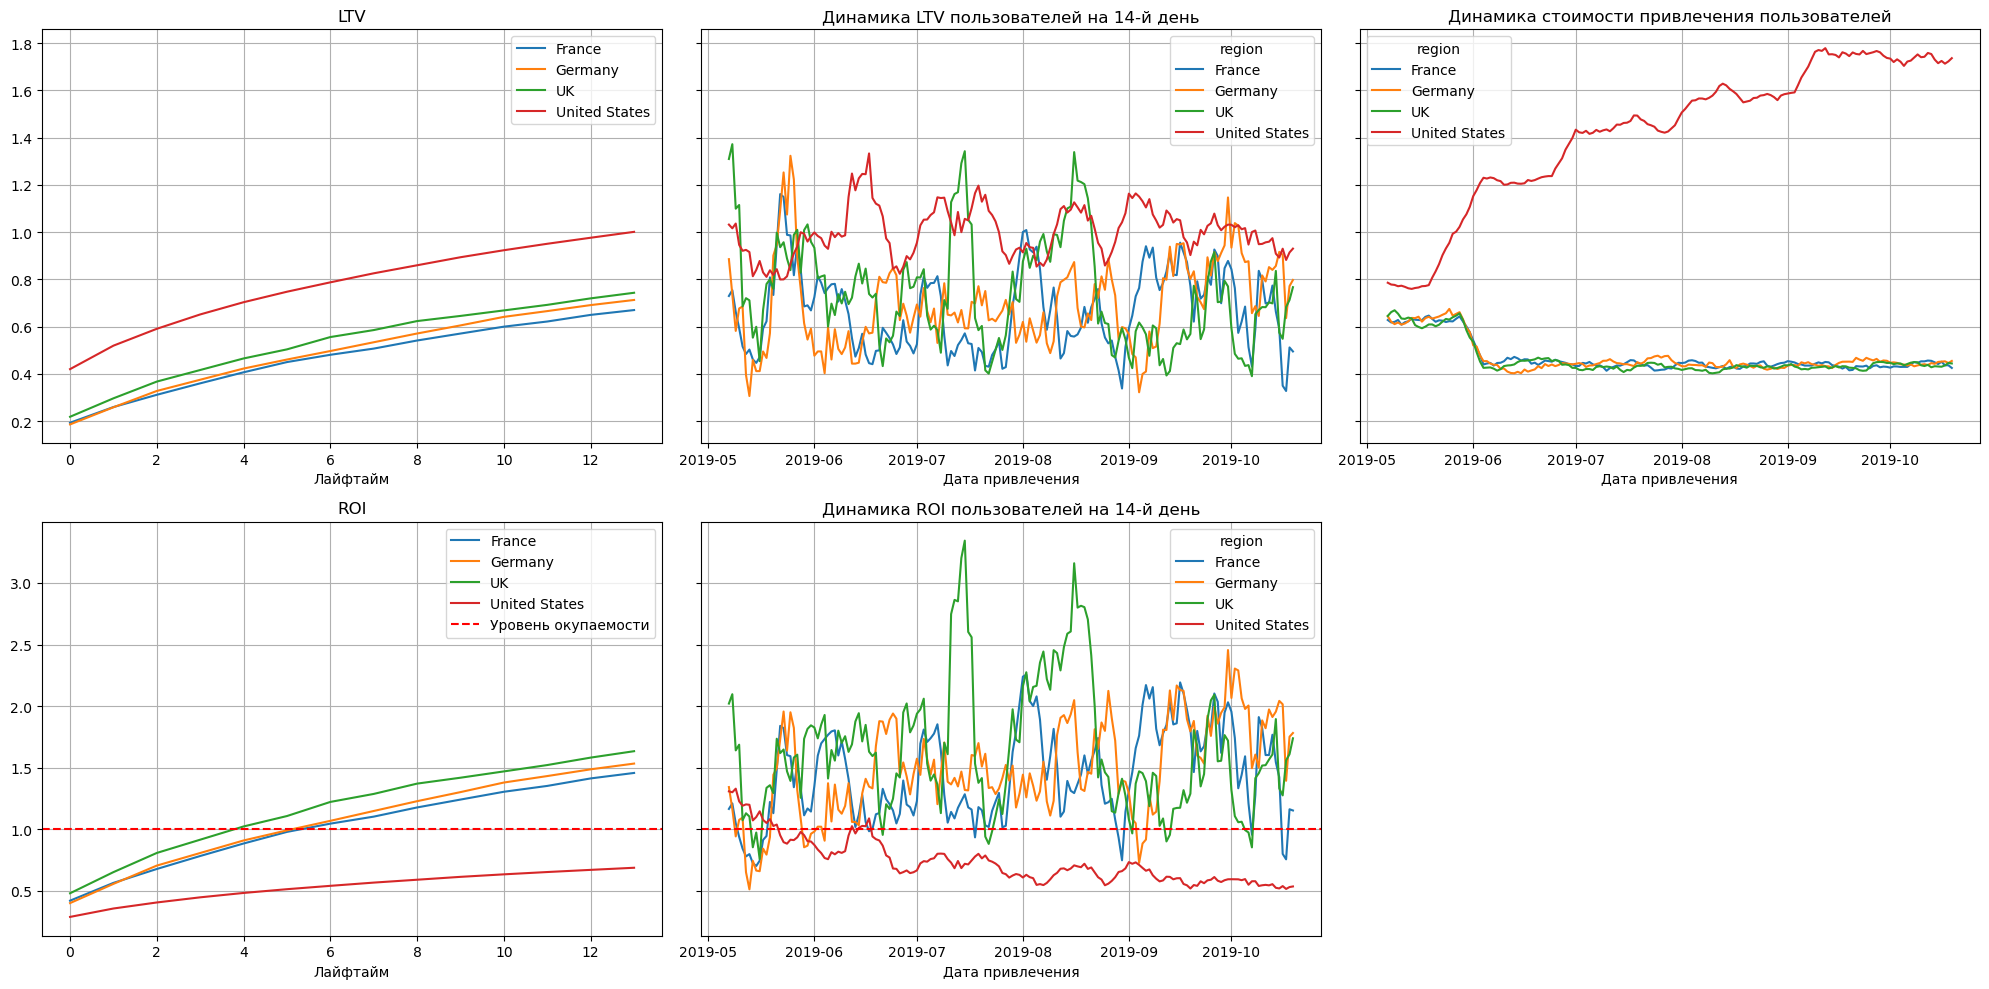

In [65]:
# проанализируем окупаемость с разбивкой по странам

dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_adv, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=7
)    

Из представленых регионов явно выделяется США: несмотря на самый высокий LTV, это единственный не окупившийся регион, в котором стоимость привлеченяи пользователей существенно отличается от осталных и стремительно растет.

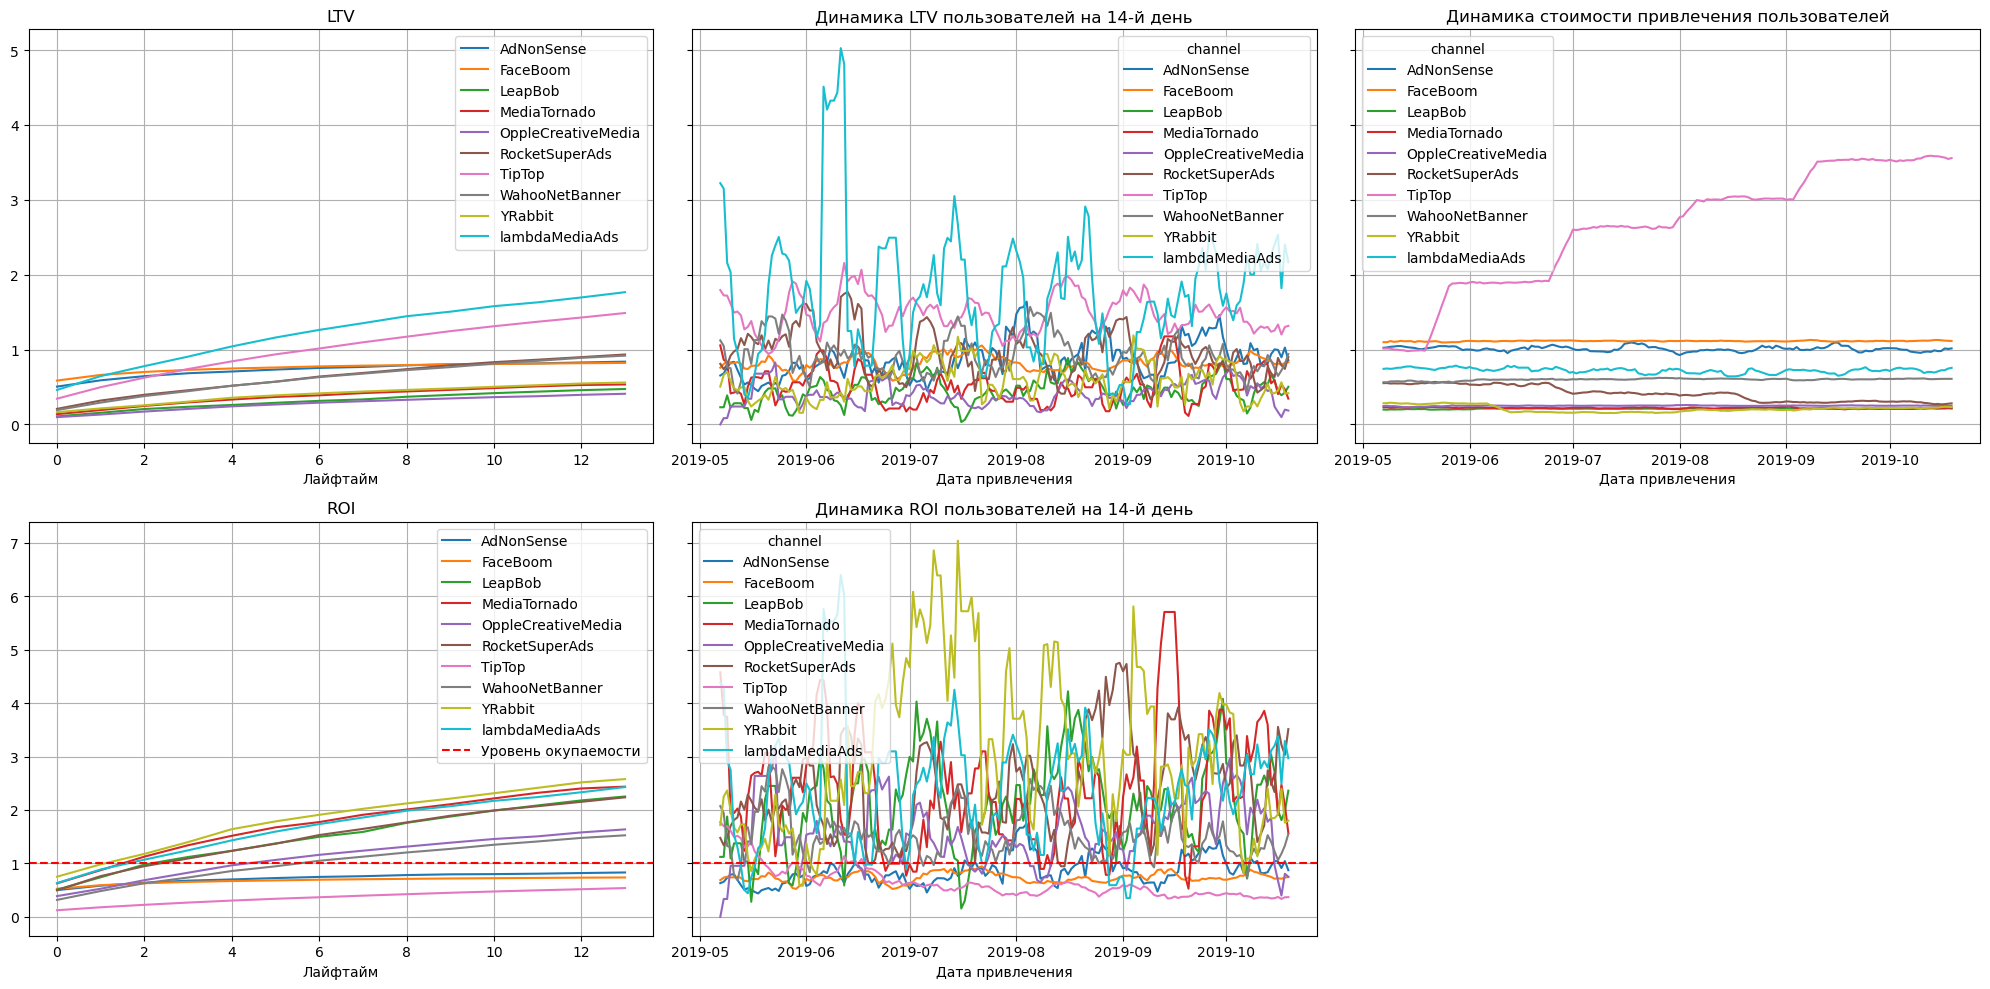

In [66]:
# проанализируем окупаемость с разбивкой по рекламным каналам:

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_adv, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=7
)

Из 3х неокупившихся каналов привлечения 2 из них являются топовыми по числу пользователей для США и к тому же самыми дорогими для привлечения. Особенно это касается TipTop. В то время, как с каналами для остальных регионов почти все в порядке.

Промежуточный вывод: Из представленных графиков наблюдаются некоторые закономерности: 
        - единственный неокупаемый регион - США
        - стоимость привлечения пользователей в США значитально больше, чем в остальных регионах 
        - единсвенная окупаемая платформа - ПК
        - из 3х неокупаемых каналов рекламы 2 находятся в США и только 1 в Европе, однако Европа является окупаемым регионом.
Можно предположить, что проблема в стоимости рекламных компаний, проводимых в США, а просадки окупаемости в разбивке по устройствам связавны с тем, что в основном ими пользуются жители страны с самой догой и не эффективной рекламой, то есть США. Проверим это:                 

In [67]:

profiles_device = profiles.pivot_table(index='region', columns='device', values='user_id', aggfunc='nunique')

profiles_device

device,Android,Mac,PC,iPhone
region,,,,
France,5252,1838,6940,3420
Germany,4440,1584,5945,3012
UK,5141,1778,7138,3518
United States,20199,24842,10432,44529


<AxesSubplot:title={'center':'Разбивка утройств по странам'}, xlabel='region'>

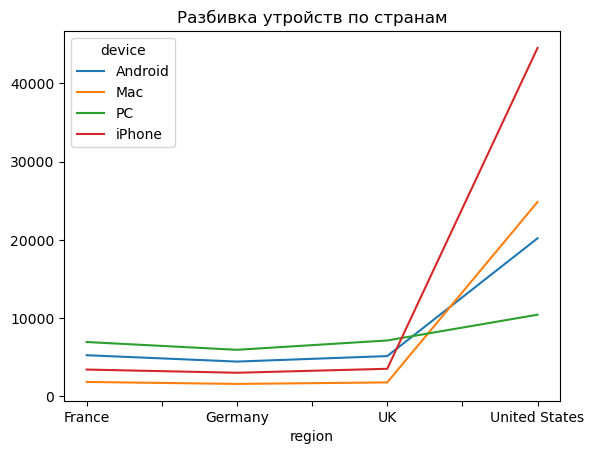

In [68]:
profiles_device.plot(title='Разбивка утройств по странам')

Действительно, самыми "неэффективными" устройствами пользуются жители страны с самой "неэффективной" рекламой. От этого возникает иллюзия, что неокупаются пользователи в зависимости от устройств. 
Непонятным остается источник рекламы AdNonSense, который имеет наибольший процент платящих пользователей в Европе и возможно дело конверсии или удержании пользователей, построим графики по каналам рекламы:

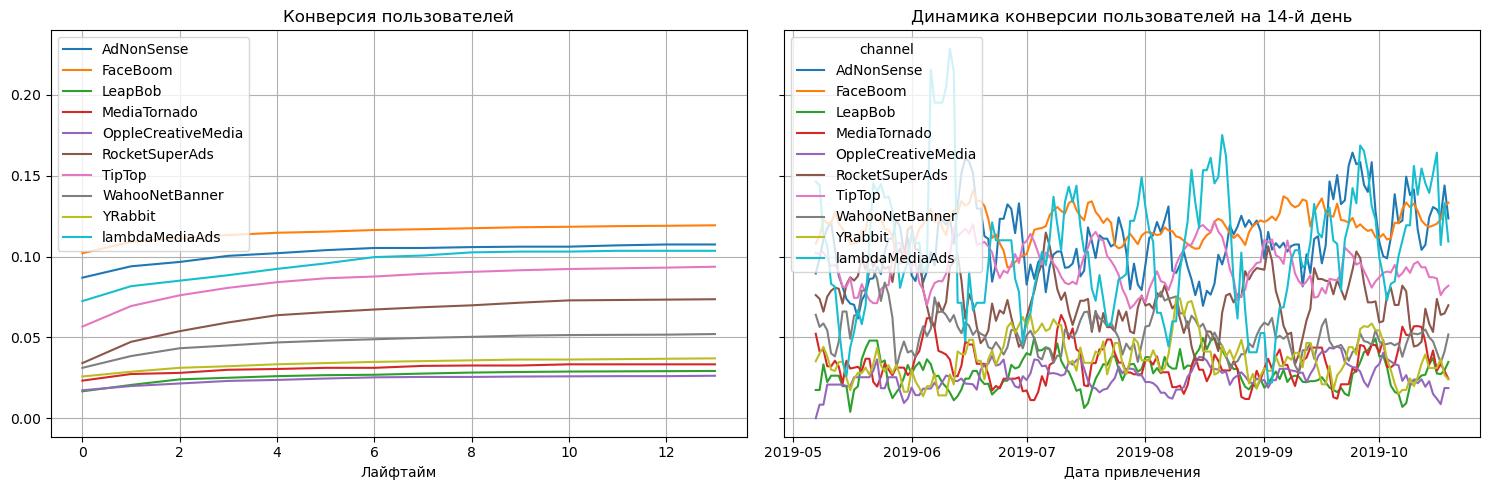

In [69]:
dimensions = ['channel']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_adv, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

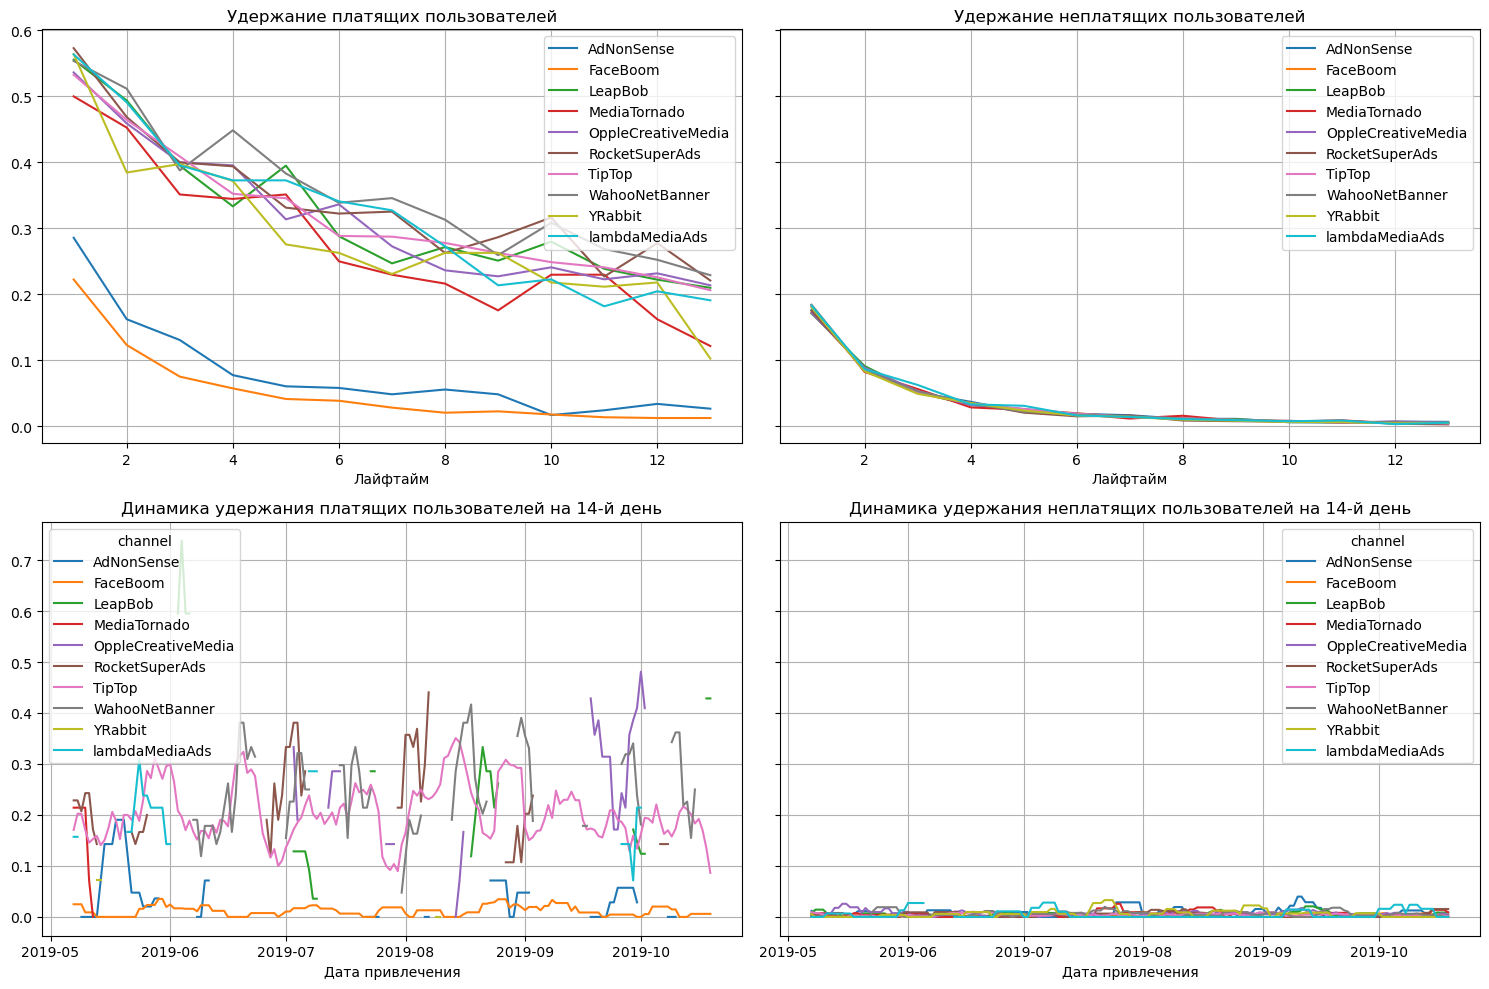

In [70]:
dimensions = ['channel']
retention_raw, retention_grouped, retention_history = get_retention(
    profiles_adv, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

Конверсия пользвателей через канал AdNonSense неплохая, однако удеражание резко стремится к нулю.

**Вывод:**

Несмотря на то, что на iphone и MAC доля платящих полльзователей больше - это разница не столь велика, чтобы разбираться в причинах такой тенденцции. Тем не менее можно сказать, что это самые дорогие устройства, это говорит о потенциальной платежеспособности влдельцев устройсвт, но не скзывается на анализе прибыльности приложения.    


По пердоставленным данным была проделана следующая работа:

1) Предобработка данных:

приведение столцов к единому стилю, изменение типов данных, поиск пропусков и дубликатов.

2) В результате исследовательского анализа данных были выявлены следующие зависимости:

 - наибольшее количество пользователей в том числе платящих находятся в США
 - большинство ползователей испольщуют iphone и MAC и наибольший процент этих устройств сконцентрирован в США
 - рекламные канали США и стран европы не пересекаются друг с другом
 - между каналами рекламы привлекших наибольшее общее число пользователей и каналами привлекших наибольший процент платящих пользователей прямой связи нет. 
 
3) Анализ маркетинга продемонстрировал следующие данные: 
 - общая сумма затрат на рекламу составила 105 000$ из которых 83% уходят на 2 источника рекламы из США ТipTop и FaceBoom
 - Расходы на рекламу по этим 2 источникам стабильно увеличиваются. Так же немного увеличивается расходы на топ 1 по привлечению пользователей из Европы AdNonSense в то время, как общий тренд идет на снижение расходов, что скорее всего взаимосвязано.  

3) Оценка окупаемости рекламы: 

 - единственное устройство на котором окупилась реклама - PC, однако это устройство является топ 1 в Евроме и в тоже время на последнем месте по использованию в США, что застовляет рассматривать скорее регионы, чем устройства. 
 - единственный не окупившийся регоин - США, несмотря на то, что большая часть бюджета была направлена именно туда. Причем динамика привлечения пользователей там стабильно растет, в то время как в остальных странах идет тренд на снижение стоимости. 
 - ниже планки окупаемости оказались рекламных канала: FaceBoom, TipTop и AdNonSense, при этом динамика стоимости привлечения пользователей TipTop стабильно растет.
 
Из полученных данных можно сделать вывод, что топовые рекламные канали, такие как FaceBoom, TipTop, AdNonSense несмотря на наилучшую конверсию в платящих пользователей все равно не окупаются. TipTop ввиду дороговизны привлечения в пересчете на одного клиента, причем в динамике цена только увеличивается, FaceBoom и AdNonSense имеют значительно более низктй процент удержания пользователей. Через американские рекламные каналы переходят основные пользователи iphone и MAC, от сюда такие просадки окупаемости по устройствам.

Рекомендуется комендуется сократить финансирование трех упомянутых рекламных каналов в пользу вложения средств в такие окупаемые каналы с нормальной конверсией и удержанием пользователей как: RocketSuperAds и YaRabbit для США и lambdaMediaAds и WahooNetBanner для Европы.